## Kalashnik 1994


In [1]:
# General
import glob
import os.path
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.colors import Normalize
# from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import pandas as pd

# Data treatment
import dask as da
from dask.diagnostics import ProgressBar
import zarr
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from scipy.signal import argrelextrema
from datetime import datetime

# Custom
import functions as f

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PRMS = {'save_figs':       False,
          'ds_glob_path':    '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
}

### OPEN DATA
dsg = xr.open_dataset(PRMS['ds_glob_path'])
print('Nb of storms: {}'.format(len(dsg.time)))

### Add intensification parameters
dsg2 = xr.open_dataset('/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_17102022_with_extra_params.nc')
dsg['Vmax_dot_smth_IBT'] = xr.DataArray(
    data=np.array(dsg2['Vmax_dot_smth_IBT']),
    coords={'time': dsg.time}
)
dsg['Vmax_dot_IBT'] = xr.DataArray(
    data=np.array(dsg2['Vmax_dot_IBT']),
    coords={'time': dsg.time}
)
dsg['R17_dot_IBT'] = xr.DataArray(
    data=np.array(dsg2['R17_dot_IBT']),
    coords={'time': dsg.time}
)
dsg['R17_dot_smth_IBT'] = xr.DataArray(
    data=np.array(dsg2['R17_dot_smth_IBT']),
    coords={'time': dsg.time}
)

### Kinetic energy
K1_SAR = dsg['Vmax_1D'] * (dsg['Vmax_dot_smth_IBT'] * 3600) * ((dsg['R17_1D'] * 1000) ** 2)
K2_SAR = dsg['R17_1D'] * 1000 * (dsg['R17_dot_smth_IBT'] * 1000 * 3600) * (dsg['Vmax_1D'] ** 2)
K1_IBT = dsg['Vmax_IBT'] * (dsg['Vmax_dot_smth_IBT'] * 3600) * ((dsg['R34_IBT']) ** 2) 
K2_IBT = dsg['R34_IBT'] * (dsg['R17_dot_smth_IBT'] * 1000 * 3600) * (dsg['Vmax_IBT'] ** 2)

dsg['dKdt_SAR'] = K1_SAR + K2_SAR
dsg['dKdt_IBT'] = K1_IBT + K2_IBT

Nb of storms: 335


In [3]:
### FILTER
dsg = dsg.where(dsg.distance_to_coast > dsg.R17_1D * 1000, drop=True)
dsg = dsg.where(abs(dsg.lat_center) < 30, drop=True)
# dsg = dsg.where(dsg.lon_center < -50, drop=True) # Keep only USA best-track agencies
# dsg = dsg.where(dsg.distance_to_coast > 200000, drop=True)
print('Nb of storms: {}'.format(len(dsg.time)))

Nb of storms: 101


In [4]:
### FUNCTIONS
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def vorticity(r, v):
    '''Relative vorticity'''
    dr = 1000 # meters
    return (1 / r) * np.gradient(r * v, dr)

def h80(r, vm, rm, B, lat):
    '''Holland 1980 profile.'''
    fcor = coriolis(lat)
    V    = r * 0.
    V    = np.sqrt((vm ** 2) * ((rm / r) ** B) * np.exp(1 - (rm / r) ** B) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def rkne_x(r, vm, rm, x):
    '''Modified Rankine profile'''
    V          = vm * (r / rm)
    V_ou       = vm * (rm / r) ** x
    V[r >= rm] = V_ou[r >= rm]
    return V

In [5]:
# plt.hist(np.log(abs(dsg.dKdt_IBT)), bins=50)

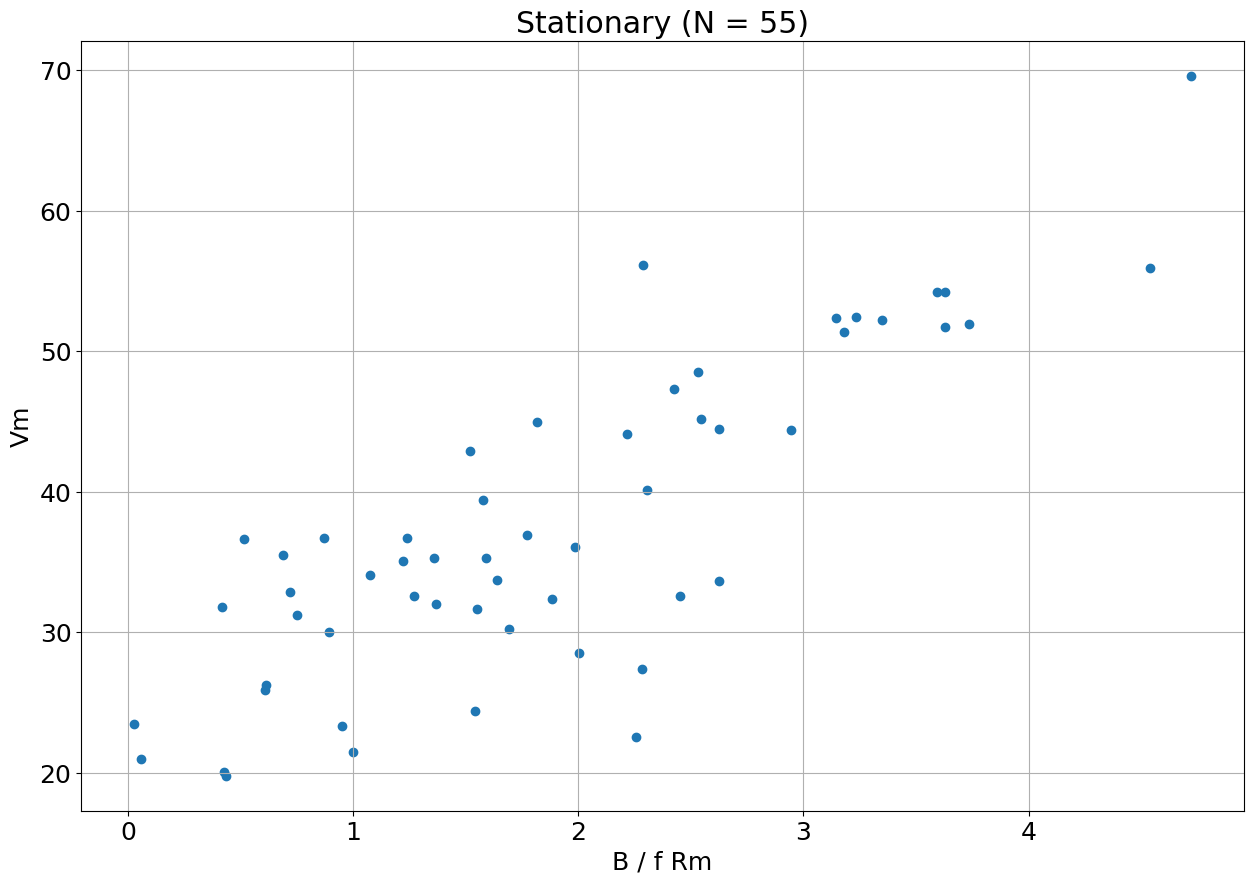

In [6]:
### Stationary case
# We require np.log(abs(dsg.dKdt_SAR)) > 33 to remove extreme outliers
# dKdt_IBT doesn't work well..

d = dsg.where((np.log(abs(dsg.dKdt_SAR)) < 35) & (np.log(abs(dsg.dKdt_SAR)) > 33), drop=True)

plt.title('Stationary (N = {})'.format(len(d.time)))
plt.scatter(d.B_hol / (abs(coriolis(d.lat_center)) * d.Rmax_1D * 1000), d.Vmax_1D)
plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

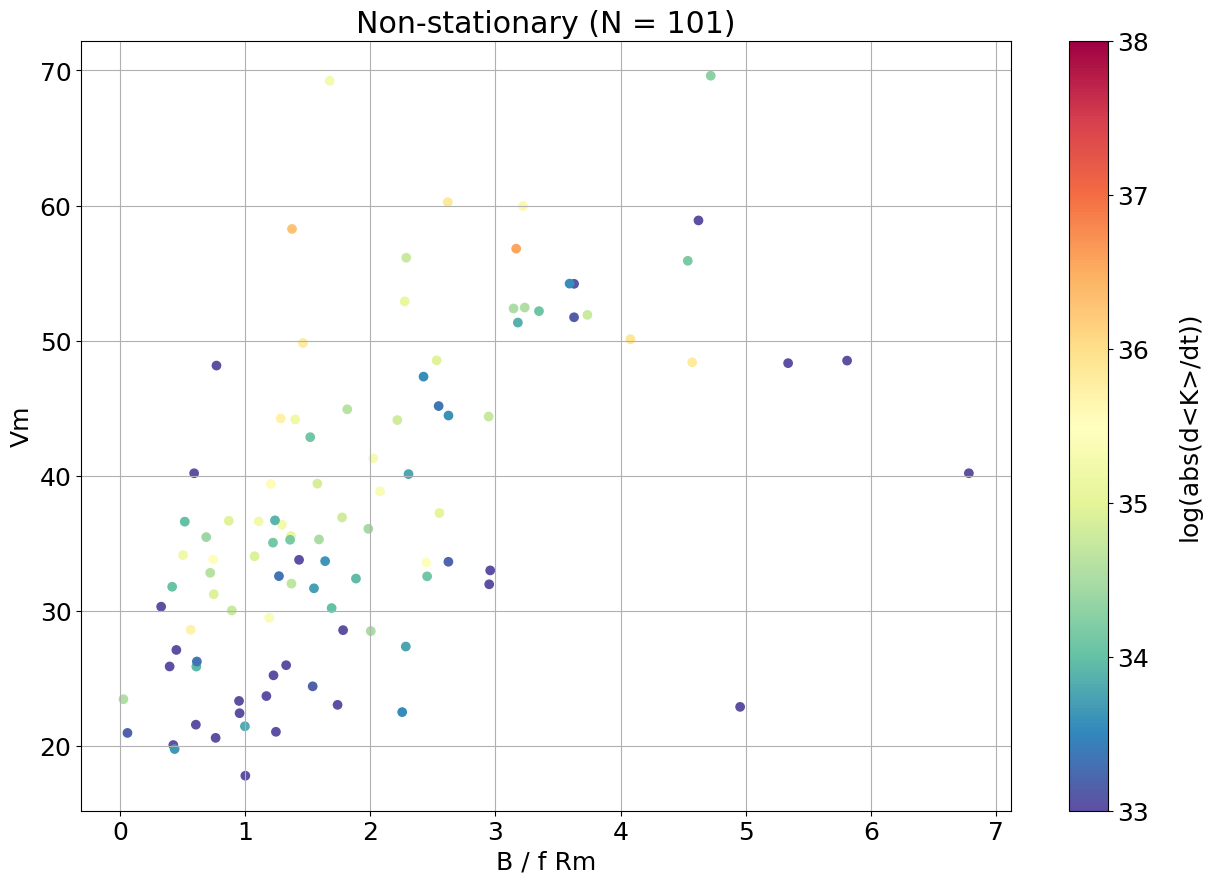

In [7]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')

plt.title('Non-stationary (N = {})'.format(len(dsg.time)))
plt.scatter(dsg.B_hol / (abs(coriolis(dsg.lat_center)) * dsg.Rmax_1D * 1000), dsg.Vmax_1D, c=np.log(abs(dsg.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap)

plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

In [8]:
# ratio = K1_SAR / K2_SAR
# plt.hist(ratio[np.isfinite(ratio)], bins=100)
# plt.xlim(-10, 10)

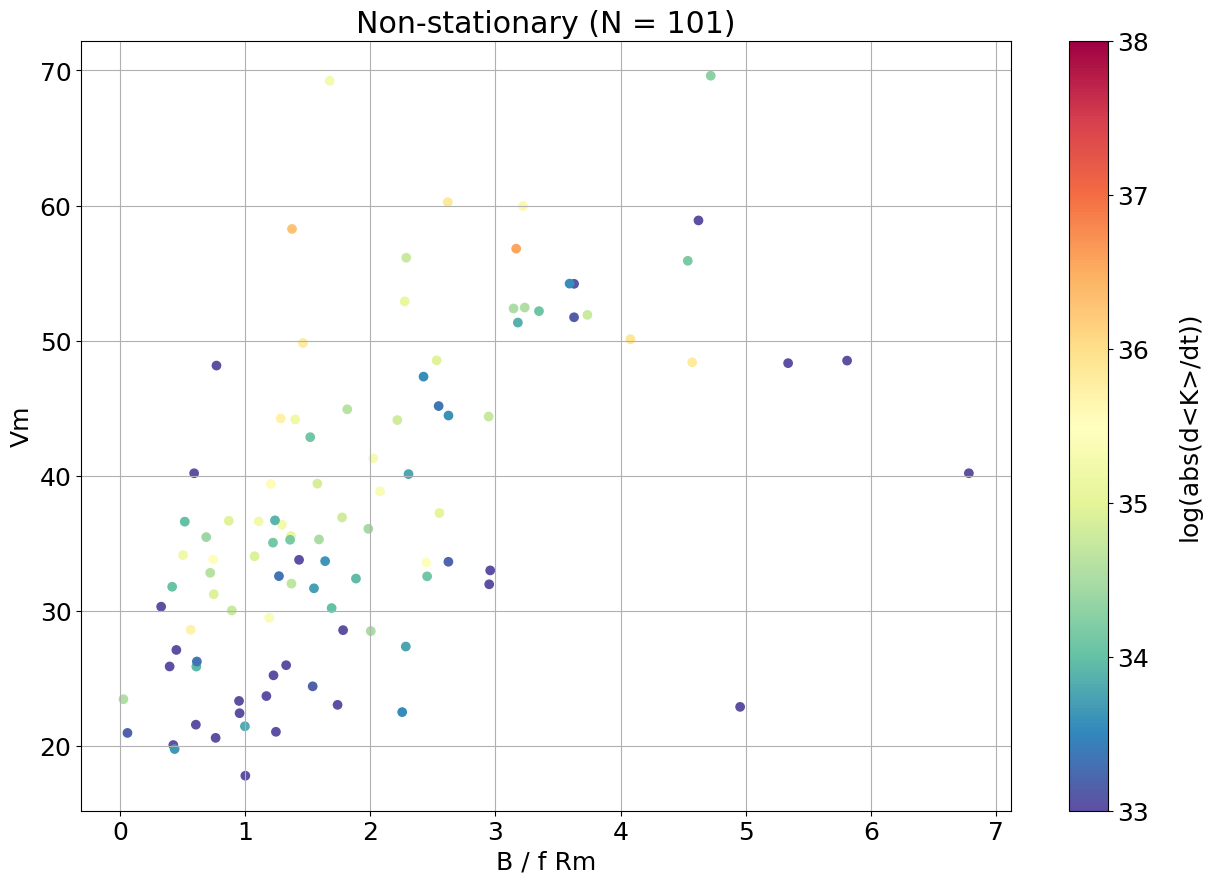

In [13]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')

plt.title('Non-stationary (N = {})'.format(len(dsg.time)))
plt.scatter(dsg.B_hol / (abs(coriolis(dsg.lat_center)) * dsg.Rmax_1D * 1000), dsg.Vmax_1D, c=np.log(abs(dsg.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap)

plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

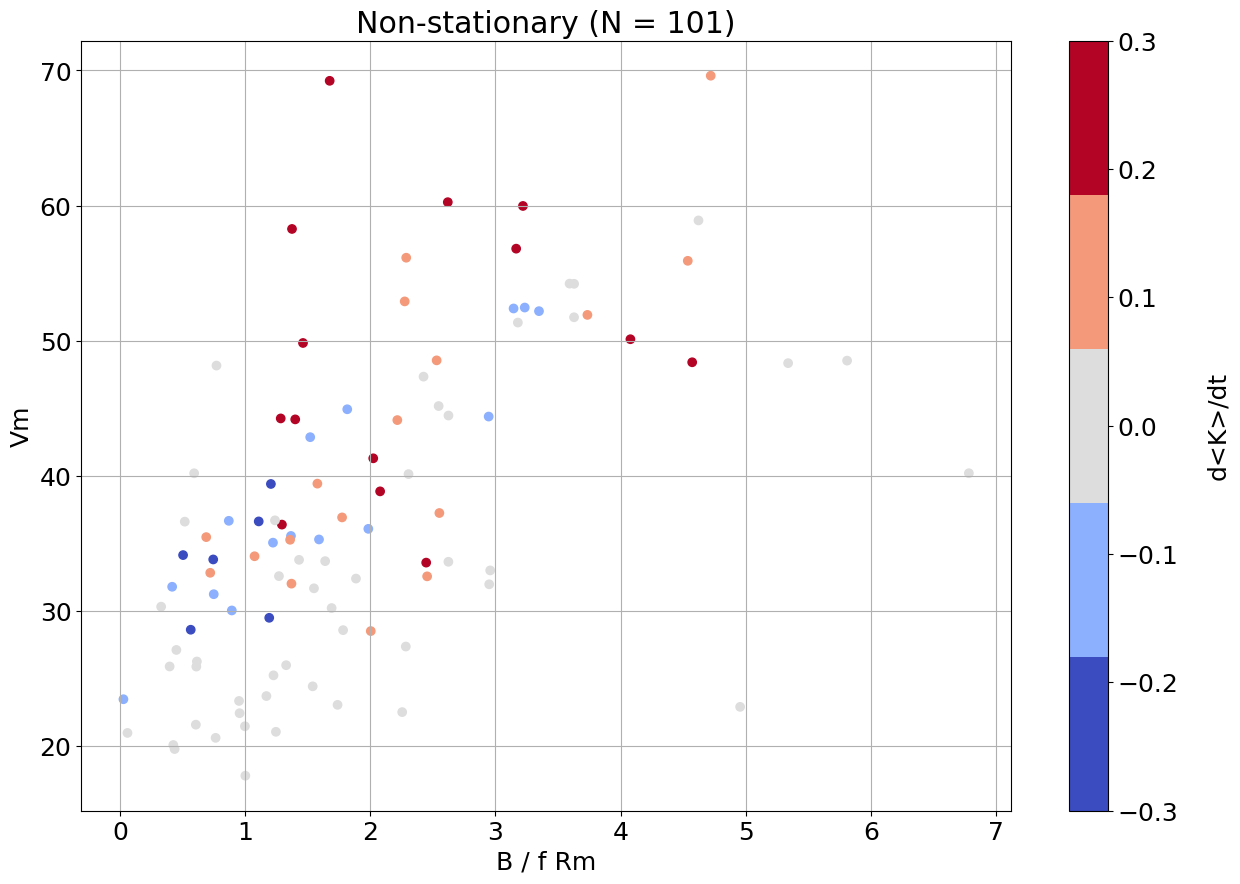

In [10]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('coolwarm', 5)

plt.title('Non-stationary (N = {})'.format(len(dsg.time)))
plt.scatter(dsg.B_hol / (abs(coriolis(dsg.lat_center)) * dsg.Rmax_1D * 1000), dsg.Vmax_1D, c=dsg.dKdt_SAR / 1e16, vmin=-0.3, vmax=0.3, cmap=cmap)

plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

cbar    = plt.colorbar()
cbar.set_label('d<K>/dt', rotation=90)
cbar.ax.get_yaxis().labelpad=20

In [11]:
d1 = dsg.where(dsg.sat_file == 'rs2--owi-cm-20210421t094352-20210421t094508-00003-F7A21_sw.nc', drop=True).isel(time=0)
d2 = dsg.where(dsg.sat_file == 's1b-ew-owi-cm-20190223t202348-20190223t202552-000003-01C2E0_sw.nc', drop=True).isel(time=0)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
# SAR profiles
ws1 = d1.wind_speed.mean(dim='theta', skipna=True)
st1 = d1.wind_speed.std(dim='theta', skipna=True)
ws2 = d2.wind_speed.mean(dim='theta', skipna=True)
st2 = d2.wind_speed.std(dim='theta', skipna=True)
plt.plot(ws1.rad / 1000, ws1, linewidth=3, label='{} SAR profile, B = {:.1f}'.format(d1.storm_name.item().item(), d1.B_hol), c='tab:red')
plt.fill_between(ws1.rad / 1000, ws1 - st1, ws1 + st1, color='tab:red', alpha=0.3)
plt.plot(ws2.rad / 1000, ws2, linewidth=3, label='{} SAR profile, B = {:.1f}'.format(d2.storm_name.item().item(), d2.B_hol), c='tab:blue')
plt.fill_between(ws2.rad / 1000, ws2 - st2, ws2 + st2, color='tab:blue', alpha=0.3)

plt.xlabel('Distance from TC center (km)')
plt.ylabel('Wind speed (m/s)')
plt.minorticks_on()
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
# plt.xlim(0, 150);plt.ylim(7, 50)

plt.legend(loc='upper right', frameon=True)

In [ ]:
# SAR profiles
plt.plot(ws1.rad / 1000, ws1.rad * (ws1 ** 2), linewidth=3, label='{} SAR rV^2, B = {:.1f}'.format(d1.storm_name.item().item(), d1.B_hol), c='tab:red')
plt.plot(ws2.rad / 1000, ws2.rad * (ws2 ** 2), linewidth=3, label='{} SAR rV^2, B = {:.1f}'.format(d2.storm_name.item().item(), d2.B_hol), c='tab:blue')

plt.xlabel('Distance from TC center (km)')
plt.ylabel('Wind speed (m/s)')
plt.minorticks_on()
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
# plt.xlim(0, 150);plt.ylim(7, 50)

plt.legend(loc='lower right', frameon=True)